In [24]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

In [25]:
drive.mount('/content/drive')
DIR = "drive/My Drive/Notebooks/Thesis/Readmissions/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

In [27]:
!nvidia-smi

Mon Jun 29 12:32:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    31W / 250W |  15363MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Natural Language

In [28]:
import string
import nltk
from tqdm import tqdm
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [29]:
def clean_text(texts):
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]
    
    return texts

In [30]:
adm_notes = adm_notes.dropna(subset=['TEXT'])

adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

# Model
## Words, Train and Test

In [31]:
from sklearn.model_selection import train_test_split

Repartition data

In [32]:
df_train, df_test = train_test_split(adm_notes, test_size=0.3)

Subsample non-readmitted patients to match size of readmitted ones

In [33]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [34]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [35]:
df_test, df_val = train_test_split(df_test, test_size=0.5)

df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)
df_val = df_val.sample(n = len(df_val)).reset_index(drop = True)

# Recurrent Neural Network

In [36]:
!pip install transformers

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_hub as hub
import tensorflow as tf
from keras.models import Model
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, glue_convert_examples_to_features
from transformers import TFBertForSequenceClassification, BertTokenizer

In [38]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

In [39]:
pad_token=0
pad_token_segment_id=0
max_length=512

def convert_to_input(texts):
  input_ids, attention_masks, token_type_ids = [], [], []
  
  for text in tqdm(texts, position=0, leave=True):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, return_token_type_ids=True)
    
    i, t = inputs["input_ids"], inputs["token_type_ids"]
    m = [1] * len(i)

    padding_length = max_length - len(i)

    i = i + ([pad_token] * padding_length)
    m = m + ([0] * padding_length)
    t = t + ([pad_token_segment_id] * padding_length)
    
    input_ids.append(i)
    attention_masks.append(m)
    token_type_ids.append(t)
  
  return [np.asarray(input_ids), 
            np.asarray(attention_masks), 
            np.asarray(token_type_ids)]

X_train_input = convert_to_input(df_train['TEXT'])
X_test_input = convert_to_input(df_test['TEXT'])
X_val_input = convert_to_input(df_val['TEXT'])

100%|██████████| 845/845 [00:33<00:00, 25.11it/s]


In [40]:
def to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y

train_data = (X_train_input[0], X_train_input[1], X_train_input[2], df_train['READM_WITHIN_30'])
test_data = (X_test_input[0], X_test_input[1], X_test_input[2], df_test['READM_WITHIN_30'])
val_data = (X_val_input[0], X_val_input[1], X_val_input[2], df_val['READM_WITHIN_30'])

train_ds = tf.data.Dataset.from_tensor_slices(train_data).map(to_features).shuffle(len(df_train['READM_WITHIN_30'])).batch(10)
test_ds = tf.data.Dataset.from_tensor_slices(test_data).map(to_features).batch(10)
val_ds = tf.data.Dataset.from_tensor_slices(val_data).map(to_features).batch(10)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_ds, epochs=3, validation_data=val_ds) 

Epoch 1/3
440/440 [==============================] - 330s 750ms/step - loss: 0.6957 - accuracy: 0.5059 - val_loss: 0.6915 - val_accuracy: 0.5041
Epoch 2/3
440/440 [==============================] - 327s 743ms/step - loss: 0.6949 - accuracy: 0.5068 - val_loss: 0.6881 - val_accuracy: 0.5633
Epoch 3/3
440/440 [==============================] - 327s 744ms/step - loss: 0.6824 - accuracy: 0.5671 - val_loss: 0.6780 - val_accuracy: 0.5964


In [42]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(test_ds, verbose=1)
y_pred_class = np.argmax(y_pred[0], axis=1)

print(classification_report(df_test['READM_WITHIN_30'], y_pred_class, digits=3))
print(roc_auc_score(df_test['READM_WITHIN_30'], y_pred_class))

85/85 [==============================] - 20s 232ms/step
              precision    recall  f1-score   support

           0      0.652     0.416     0.508       418
           1      0.578     0.782     0.665       427

    accuracy                          0.601       845
   macro avg      0.615     0.599     0.586       845
weighted avg      0.614     0.601     0.587       845

0.5992346738679784


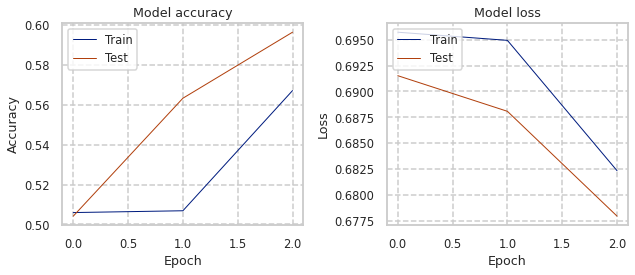

In [43]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()

In [44]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


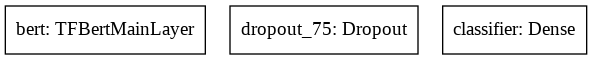

In [45]:
from keras.utils import plot_model
plot_model(model)